In [1]:
import mesa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Agents

In [2]:
class Market:
    def __init__(self, price=1, history=dict()):
        self.price = price # Текущая цена
        self.history = history # JSON-подобный документ с полной историей
        self.step = step # Текущий шаг (временной интервал)



class Seller(mesa.Agent):

    def __init__(self, model):
        super().__init__(model)
        self.days_with_no_extra_demand = 0
        self.forecast_horizon = 12

        self.reserve_history = [10]
        self.produce_history = [5]
        self.sold_history = [5]
        self.price_history = [50]
        self.extra_demand_history = [1]

    def product(self):

        reserve_avg = np.mean(self.reserve_history[-self.forecast_horizon:])
        produce_avg = np.mean(self.produce_history[-self.forecast_horizon:])
        sold_avg = np.mean(self.sold_history[-self.forecast_horizon:])
        price_avg = np.mean(self.price_history[-self.forecast_horizon:])
        extra_demand_avg = np.mean(self.extra_demand_history[-self.forecast_horizon:])

        # Тут индексы -1, т.к. мы добавляем новую запись и они станут -2
        self.reserve_history.append(self.reserve_history[-1] + self.produce_history[-1]) # Берём из предыдущего периода + сколько произведено в предыдущем периоде, а потом в house_bought будем убирать
        self.sold_history.append(0) # Потом в house_bought будем добавлять
        self.produce_history.append(self.produce_history[-1]) # Потом поменяем
        self.price_history.append(self.price_history[-1]) # Потом поменяем
        self.extra_demand_history.append(self.extra_demand_history[-1]) # Потом поменяем

        #if (sold_avg + extra_demand_avg) > reserve_avg:
        #    self.produce_history[-1] += min([extra_demand_avg, 5])
        #else:
        #    self.produce_history[-1] = self.produce_history[-1]*0.8
        #self.produce_history[-1] -= self.days_with_no_extra_demand

        self.produce_history[-1] = round((sold_avg + extra_demand_avg) * min([(sold_avg + extra_demand_avg)/(reserve_avg+1), 1])) + (20-self.reserve_history[-1])


        if self.produce_history[-1]<0:
            self.produce_history[-1] = 0
        if self.extra_demand_history[-1] == 0:
            self.days_with_no_extra_demand +=1
        elif self.extra_demand_history[-1] > 0:
            self.days_with_no_extra_demand = 0
        
    def house_bought(self):
        self.reserve_history[-1] -= 1
        self.sold_history[-1] += 1


         
class Buyer(mesa.Agent):

    def __init__(self, model, age=-1):
        super().__init__(model)
        self.wage = np.random.random() * 10
        self.wealth = np.random.random() * 25 - 10
        self.will_to_buy = 0
        self.n_of_houses = 0
        self.n_children = 0
        if age == -1:
            self.age = np.random.randint(0, 40)
        else:
            self.age = age

    def change_state(self):
        if self.age > 15:
            newborn = np.random.choice(a=[0,1], p=[0.96,0.04])
            self.wealth += self.wage
        else:
            newborn = 0

        if newborn > 0:
            self.create_agents(self.model, n=newborn, age=0)
        
        self.n_children += newborn
        self.will_to_buy += (self.n_children + 1) / (self.n_of_houses + 1)
       
        if self.age > 40:
            self.remove()
        else:
            self.age += 1
    
    def buy(self):
        seller = self.model.agents_by_type[Seller][0]
        seller_price = seller.price_history[-1]
        if ((self.wealth - (20 - self.will_to_buy)*seller_price) > 1) and (self.wealth > seller_price):
            if seller.reserve_history[-1] > 0:
                self.wealth -= seller_price
                self.will_to_buy -= 100
                self.n_of_houses += 1
                seller.house_bought() # Change seller's reserves
            else:
                self.model.extra_demand += 1
    
    def __str__(self):
        return 'buyer'


class Government(mesa.Agent):

    def __init__(self, model):
        super().__init__(model)

# World

In [3]:
class WorldModel(mesa.Model):
    def __init__(self, n, seed=None):
        super().__init__(seed=seed)
        self.num_agents = n
        # Create agents
        Buyer.create_agents(model=self, n=n)
        Seller.create_agents(model=self, n=1)
        self.datacollector = mesa.DataCollector(
            model_reporters={
                "homes": compute_homes,
                "demand": store_extra_demand,
                "price": store_price,
                "reserve": store_reserve,
                "produce": store_product,
                "sold": store_sold,
                "population": compute_population,
                "fertility": compute_fertility
            }
        )
        self.extra_demand = 0
    
    def step(self):
        self.extra_demand = 0
        self.agents_by_type[Seller].do("product")
        self.agents_by_type[Buyer].do("change_state")
        self.agents_by_type[Buyer].do("buy")
        self.datacollector.collect(self)
    
    def __str__(self):
        return 'Current world state (settings)'

def compute_homes(model):
    agent_homes = [agent.n_of_houses for agent in model.agents_by_type[Buyer]]
    return sum(agent_homes)

def compute_population(model):
    return len(model.agents_by_type[Buyer])

def compute_fertility(model):
    agent_fertility = [agent.n_children for agent in model.agents_by_type[Buyer]]
    return sum(agent_fertility)

def store_extra_demand(model):
    return model.extra_demand

def store_price(model):
    return model.agents_by_type[Seller][0].price_history[-1]

def store_reserve(model):
    return model.agents_by_type[Seller][0].reserve_history[-1]

def store_product(model):
    return model.agents_by_type[Seller][0].produce_history[-1]

def store_sold(model):
    return model.agents_by_type[Seller][0].sold_history[-1]

# Simmulation

In [4]:
model = WorldModel(500)
for _ in range(300):
    model.step()

In [5]:
model.datacollector.get_model_vars_dataframe()

,homes,demand,price,reserve,produce,sold,population,fertility
0,0,0,50,15,8,0,512,12
1,0,0,50,23,0,0,522,22
2,0,0,50,23,0,0,515,30
3,0,0,50,23,0,0,517,46
4,0,0,50,23,0,0,523,58
...,...,...,...,...,...,...,...,...
295,241,0,50,10,7,19,772,211
296,239,0,50,5,19,12,772,208
297,237,0,50,12,12,12,773,215
298,241,0,50,7,12,17,785,232


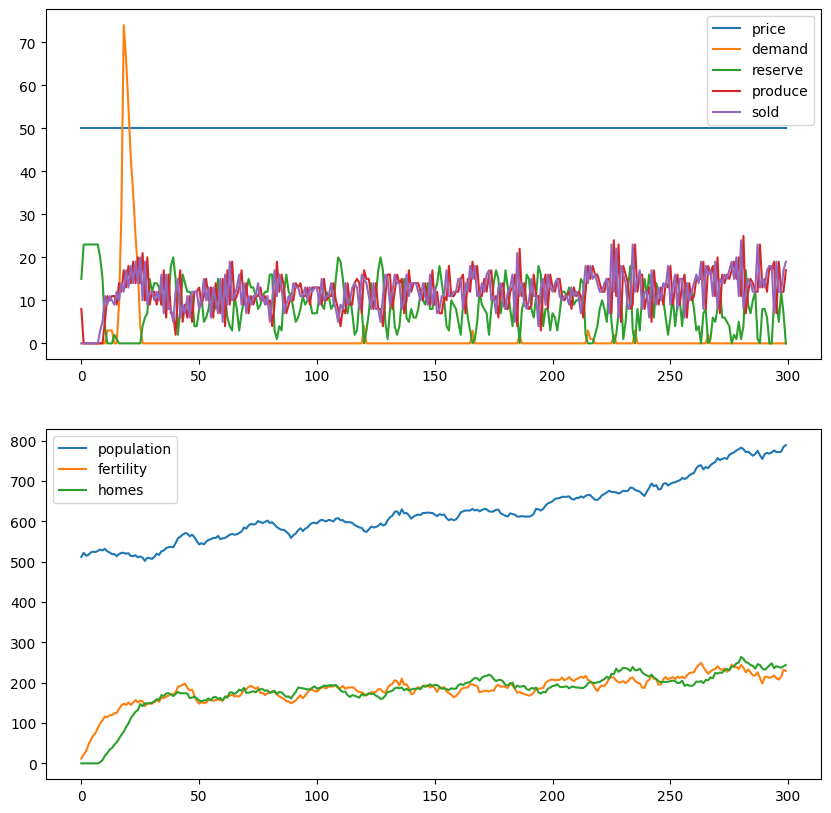

In [6]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,10))

ax1.plot(model.datacollector.get_model_vars_dataframe()[['price', 'demand', 'reserve', 'produce', 'sold']])
ax1.legend(['price', 'demand', 'reserve', 'produce', 'sold'])

ax2.plot(model.datacollector.get_model_vars_dataframe()[['population', 'fertility', 'homes']])
ax2.legend(['population','fertility', 'homes'])

In [93]:
np.random.choice(a=[0,1,2], p=[0.8,0.18,0.02])

np.int64(0)